# <i>COM-418 - Computers and Music</i> <br /> <br />  <b>Reverberation</b> 

<div align="right"><a href="https://people.epfl.ch/lucie.perrotta">Lucie Perrotta</a> and <a href="https://people.epfl.ch/paolo.prandoni">Paolo Prandoni</a>, <a href="https://www.epfl.ch/labs/lcav/">LCAV, EPFL</a></div>

In [1]:
from scipy.signal import lfilter
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy import signal
import import_ipynb
from Helpers import *

figsize=(10,5)
fs=44100

importing Jupyter notebook from Helpers.ipynb


In this notebook, we will implement **reverberation** (abbreviated as reverb). Reverberation is a phenomenon that occures naturally all the time as sound bounces on any surface it reaches. A single bounce is called an echo, and may be percieved when a sound is produced in a very simple environement, like for instance in front of a wall outside. In more complex environnements such as a room, any produced sound bounces on the walls and furniture multiple times with different distances travelled between each bounce. The total reverberation is hence complex and richer. This effect gives to the sound a natural touch that is often wanted in audio production to give some instrument more body or color.

## 1. The building blocks of a reverberator

In order to build a reverberator, let's first have a look at the components of a reverberator. 

### 1.1. Tap delay

The first important element to build a reverb is a tap delay, an effect that simply delays copies of the signal with different amplitudes, and sum them up together. This filter is FIR, avoiding all problems linked to stability, since it has no poles.

$$
    y[n] = c \cdot x[n] + \sum_{i=0}^{N} g_i \cdot x[n-M_i]
$$
where $c$ is the input gain, $N$ is the number of delay taps, $g_i$ are the gains of the taps, and $M_i$ are the delays of the taps.

Its transfer function is
$$
    H(z) = c \cdot z + \sum_{i=0}^N g_i \cdot z^{-M_i} .
$$

In [2]:
def tap_delay(x, delay_IR, pole=False):
    """
    A FIR tap delay
    x: the input signal
    delay_IR: the impulse response of the delay, as a numpy array
    pole: if True, plots the frequency response and the pole-zero plot. if False, returns the filtered signal
    """
    delays = 0
    
    for i in range(delay_IR.size):
        delays += delay_IR[i] * np.concatenate((np.full((i), 0.), x))[:x.size]
        
    if pole==True:
        b = delay_IR
        a = np.ones(1) # No pole
        freq_response(b,a)
        return zplane(b,a)
    
    return delays 

The tap delay being an FIR filter, it is always stable and do not have any pole. It features as many zeros as the size of the impulse response. Let's try to create a tap delay with an impulse reponse of size 5 and observe the corresponging pole zero plot.

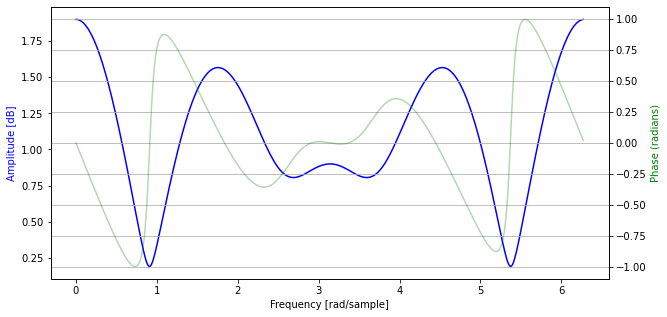

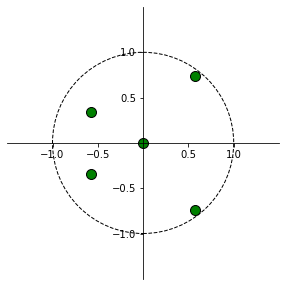

(array([ 0.57809876+0.7419058j ,  0.57809876-0.7419058j ,
        -0.57809876+0.34347074j, -0.57809876-0.34347074j,
         0.        +0.j        ]),
 array([], dtype=float64),
 1.0)

In [3]:
tap_delay(np.array([1]), np.array([1, 0, 0, .5, .4, 0]), pole=True)

### 1.2. Backward comb filter

The second element we need to create a reverb is the comb filter, or IIR delay. The IIR filter delay is simply a copy of the input signal added to the output signal delayed,
$$
    y[n] = c \cdot x[n] + g \cdot y[n-M]
$$

where the input gain $c$, the feedback gain $g$ and the delay $M>0$ are constants which can be tuned. The corresponding transfer function is

$$
    H(z) = \frac{c}{1 - gz^{-M}} .
    $$
One must hence be careful to contain the poles inside of the unit circle for the filter to be usable. 

In [4]:
def comb_filter(x, g, M, pole=False):
    """
    An IIR backward comb delay
    x: the input signal
    g: the amount of feedback in (0,1)
    M: the delay time in samples
    pole: if True, plots the frequency response and the pole-zero plot. if False, returns the filtered signal
    """
    b = np.repeat(np.conj(g),1) # Numerator of the transfer function (zeros)
    a = np.zeros(M+1) # Denomintor of the transfer function (poles)
    a[0] = 1
    a[M] = g
    
    if pole==True:
        freq_response(b,a)
        return zplane(b,a)
    
    x = lfilter(b, a, x)
    return normalize(x) # Normalize

Given the pole arrangement, the frequency response ressembles a sinusoid.

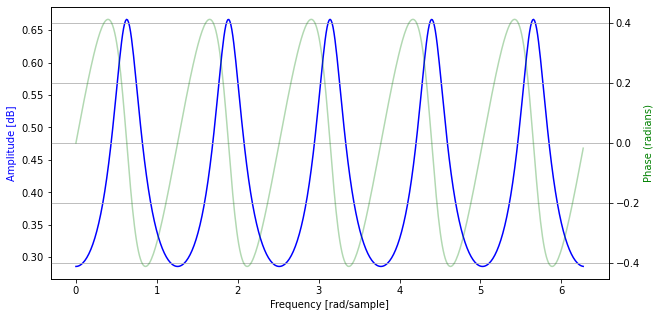

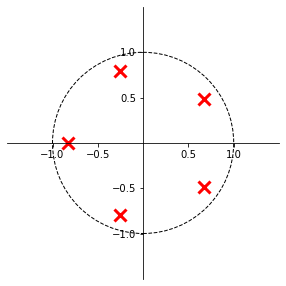

(array([], dtype=float64),
 array([-0.83255321+0.j        , -0.25727309+0.79180515j,
        -0.25727309-0.79180515j,  0.67354969+0.4893625j ,
         0.67354969-0.4893625j ]),
 1.0)

In [5]:
comb_filter(np.array([1]), .4, 5, pole=True)

### 1.3. Allpass comb filter

The last element needed to create a reverb is the all-pass comb filter. This filter simply cancels the effects of the poles with zeros in a backward comb in order to make the frequency response flat, and hence not color the sound.

When combining a backward comb filter with a simple delay, one obtains an **allpass comb filter**, which is convenient since its frequency response is flat. Its equation reads
$$
    y[n] = c \cdot x[n] + x[n-M] - g \cdot y[n-M]
$$
and its transfer function
$$
    H(z) = \frac{ c + z^{-M}}{1 + g \cdot z^{-M}} .
$$

In [6]:
def allpass_comb_filter(x, g, M, pole=False):
    """
    An IIR allpass comb delay
    x: the input signal
    g: the amount of feedback in (0,1)
    M: the delay time in samples
    pole: if True, plots the frequency response and the pole-zero plot. if False, returns the filtered signal
    """
    b = np.zeros(M+1)
    b[0] = np.conj(g)
    b[M] = 1
    a = np.zeros(M+1)
    a[0] = 1
    a[M] = g
    
    if pole==True:
        freq_response(b,a)
        return zplane(b,a)
    
    x = lfilter(b, a, x)
    return normalize(x) # Normalize

The frequency response is indeed flat as each zero has cancelled the effect of a pole!

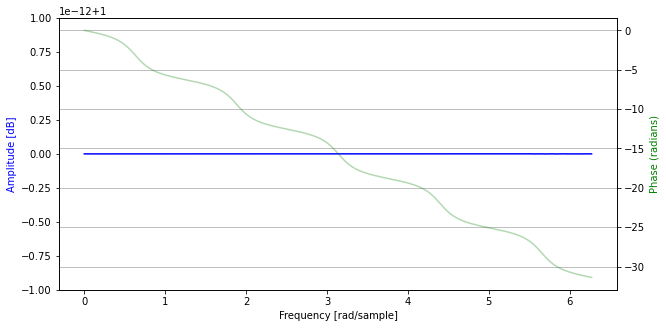

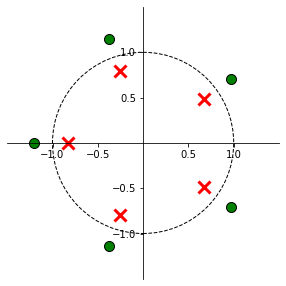

(array([-1.20112443+0.j        , -0.37116786+1.14233722j,
        -0.37116786-1.14233722j,  0.97173008+0.70600323j,
         0.97173008-0.70600323j]),
 array([-0.83255321+0.j        , -0.25727309+0.79180515j,
        -0.25727309-0.79180515j,  0.67354969+0.4893625j ,
         0.67354969-0.4893625j ]),
 1.0)

In [7]:
allpass_comb_filter(np.array([1]), .4, 5, pole=True)

### 1.4. Comparing the IRs

We can now compare the impulse responses of the 3 filters.

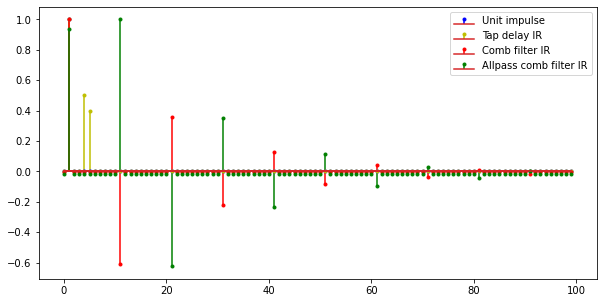

In [8]:
impulse = np.zeros(100)
impulse[1] = 1

plt.figure(figsize=figsize)
plt.stem(impulse, label = "Unit impulse", linefmt='blue', markerfmt='b.',use_line_collection=True)
plt.stem( tap_delay(impulse, np.array([1, 0, 0, .5, .4])),  linefmt='y', label="Tap delay IR", markerfmt='y.',use_line_collection=True)
plt.stem( comb_filter(impulse, 0.6, 10), label="Comb filter IR", linefmt='red', markerfmt='r.',use_line_collection=True)
plt.stem( allpass_comb_filter(impulse, 0.6, 10), label="Allpass comb filter IR", linefmt='g', markerfmt="g.", use_line_collection=True)
plt.legend()
plt.show()

## 2. Building actual reverberators

Using these building blocks, we can now move to combining them to build actual reverberators. In this section, we focus on 2 reverberators proposed in 1961 and 1979. 

### 2.1. Schroeder's reverberator

The first and main nesting of reverb filters was proposed by Schoeder in 1961. It consists of a cascade of parallel comb filters with all pass filters in series. The parallel comb structure is meant to simulate the fluctuation of the frequency response of the reverb in a room, and the series of allpass filters is designed to simulate diffusion of the sound.

<img src="https://i.imgur.com/Mx0OWIc.png" alt="Drawing" style="width: 60%;"/>

In [9]:
def schroeder_reverberator(x):
    
    # Parallel stage
    x = ( comb_filter(x, 0.805, 1801) 
        + comb_filter(x, 0.827, 1478) 
        + comb_filter(x, 0.783, 2011) 
        + comb_filter(x, 0.764, 2123) ) / 4
    
    # Series stage
    x = allpass_comb_filter(x, 0.7, 225)
    x = allpass_comb_filter(x, 0.7, 82)
    x = allpass_comb_filter(x, 0.7, 22)
    
    return normalize(x) # Normalize

### 2.2. Moorer's reverberator

Moorer’s reverberator was later proposed to feature a distinct diagram block for early reflections and late reverbaration. First, a tap delay is used to generate the early reflections, and its output is then sent to both the main output directly, as well as to a late reverberation network similar to a Schoeder’s reverberator. The late reverberation network is then delayed in order to come right after the early reflections end.

<img src="https://i.imgur.com/09CCsAR.png" alt="Drawing" style="width: 60%;"/>

In [10]:
def moorer_reverberator(x):

    # Tap delay
    delay_array = np.zeros(150)
    delay_array[40]  = .4
    delay_array[70]  = .3
    delay_array[149] = .2
    x = tap_delay(x, delay_array)
    early_reflections = x
    
    # Parallel stage
    x = ( comb_filter(x, 0.805, 1801) 
        + comb_filter(x, 0.827, 1478) 
        + comb_filter(x, 0.783, 2011) 
        + comb_filter(x, 0.764, 2123) ) / 4
    
    # Allpass stage
    x = allpass_comb_filter(x, 0.7, 225)
    
    # Delay
    late_reverb = np.concatenate((np.full(1000, 0.), x))[:x.size]
    
    return early_reflections + late_reverb

### 2.3. Impulse reponses

We can plot the impulse response of both filters.

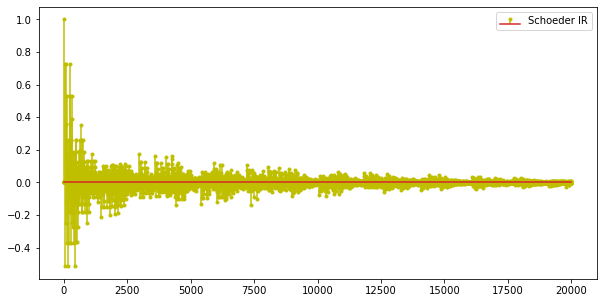

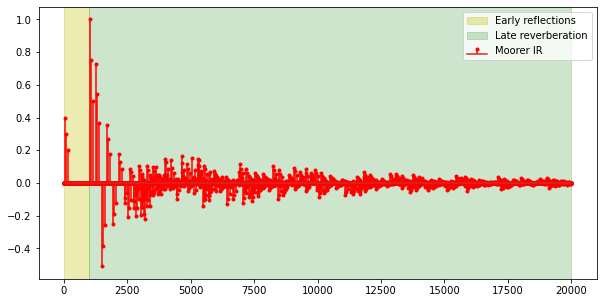

In [11]:
impulse = np.zeros(20000)
impulse[1] = 1

fig, ax = plt.subplots(figsize=figsize)
ax.stem( schroeder_reverberator(impulse),  linefmt='y', label="Schoeder IR", markerfmt='y.',use_line_collection=True)
#ax.stem(impulse, label = "Unit impulse",  linefmt='blue', markerfmt='b.',use_line_collection=True)
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=figsize)
#ax.stem(impulse, label = "Unit impulse",  linefmt='blue', markerfmt='b.',use_line_collection=True)
ax.stem( moorer_reverberator(impulse), label="Moorer IR", linefmt='red', markerfmt='r.',use_line_collection=True)
ax.axvspan(0, 1000, alpha=.3, label="Early reflections", color="y")
ax.axvspan(1001, 20000, alpha=.2, label="Late reverberation", color="g")
plt.legend()
plt.show()

## 3. Testing with guitar sample

Time to test out our reverbs with an actual sample of a guitar!

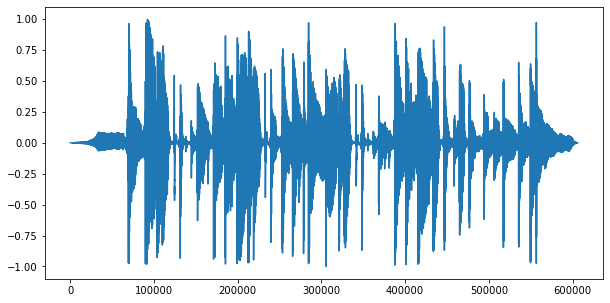

In [12]:
guitar_sample = open_audio('samples/guitar.wav')
Audio("samples/guitar.wav", autoplay=False)

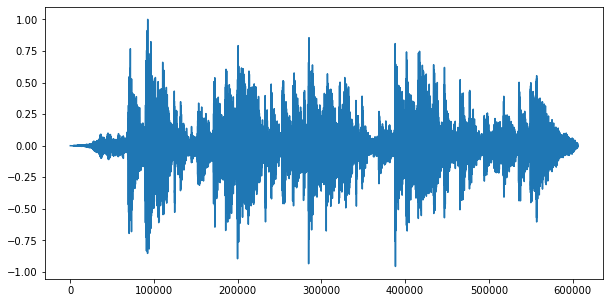

In [13]:
guitar_schroeder = schroeder_reverberator(guitar_sample)
guitar_schroeder = normalize(guitar_schroeder)
plt.figure(figsize=figsize)
plt.plot(guitar_schroeder)

Audio(guitar_schroeder, rate=fs)

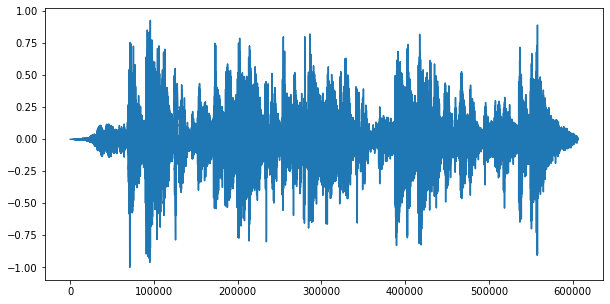

In [14]:
guitar_moorer = moorer_reverberator(guitar_sample)
guitar_moorer = normalize(guitar_moorer)
plt.figure(figsize=figsize)
plt.plot(guitar_moorer)

Audio(guitar_moorer, rate=fs)